In [1]:
import os

import pandas as pd
import numpy as np
import dataset as ds
import mne
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

mne.set_log_level('CRITICAL')

sns.set_theme(
    context='notebook',
    style='ticks',
    palette='deep',
    font='Arial',
    font_scale=1,
    color_codes=True,
    rc={'axes.unicode_minus': False}
)

In [3]:
df_sessions = pd.read_excel(os.path.join(ds.path['tbl'], 'sessions.xlsx'))
animals = df_sessions['animal_id'].unique()

In [24]:
df_power = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()
    genotype = df_sessions.query('animal_id == @animal')['genotype'].iloc[0]

    for session in sessions:
        is_good_session = (df_sessions.query('animal_id == @animal and session == @session')['reserve'] == 1).all()
        fname = os.path.join(ds.path['tmp'], animal, session, 'raw.edf')
        
        if is_good_session:
            # prep data
            fname = os.path.join(ds.path['tmp'], 'prep', 'annot_over_loco', f'{animal}_{session}_epochs.fif')
            epochs = mne.read_epochs(fname)

            power_epochs = epochs.compute_psd(fmax=30)
            df_power_session = power_epochs.to_data_frame()
            df_power_session = df_power_session.rename(columns={'condition': 'animal', power_epochs.ch_names[0]:'power'})
            df_power_session['animal'] = animal
            df_power_session['session'] = session
            df_power_session['genotype'] = genotype
    
            df_power = pd.concat([df_power, df_power_session])
            

In [25]:
df_power['power'] = 10 * np.log10(df_power['power'])
df_power['power'] += 120

(1.0, 30.0)

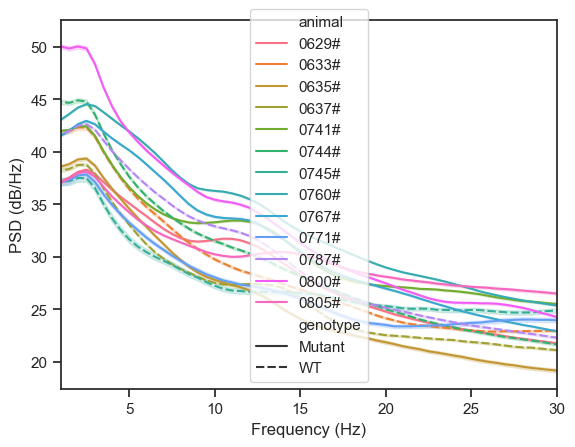

In [33]:
sns.lineplot(
    data=df_power,
    x='freq',
    y='power',
    hue='animal',
    style='genotype',
    style_order=['Mutant', 'WT']
    
)

plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (Hz)')
plt.xlim(1, 30)

In [18]:
from scipy.stats import ttest_ind, levene
from statsmodels.stats.multitest import fdrcorrection


pvalues = np.zeros(power_epochs.freqs.shape[0])
for i, freq in enumerate(power_epochs.freqs):
    A = df_power.loc[(df_power['freq'] == freq) & (df_power['genotype'] == 'WT'), 'power']
    B = df_power.loc[(df_power['freq'] == freq) & (df_power['genotype'] == 'Mutant'), 'power']
    
    _, p_square = levene(A, B)
    res = ttest_ind(A, B, equal_var=p_square > 0.05)
    pvalues[i] = res.pvalue
    
rejected, pvalues_fdr = fdrcorrection(pvalues) 

In [ ]:
df_power_mean = df_power.mean

(1.0, 30.0)

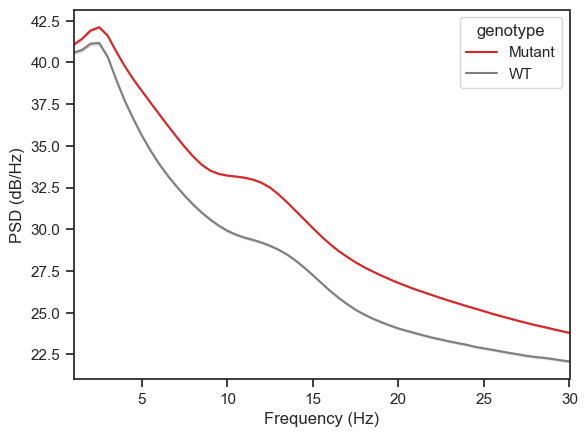

In [31]:
sns.lineplot(
    data=df_power,
    x='freq',
    y='power',
    hue='genotype',    
    palette=['tab:red', 'tab:grey'],
    hue_order=['Mutant', 'WT'],
    # units='session'
    # estimator=None
)
# pvalues_plot = np.zeros(power_epochs.freqs.shape[0])
# pvalues_plot[:] = np.nan
# pvalues_plot[pvalues_fdr < 0.01] = 55
# plt.plot(power_epochs.freqs, pvalues_plot, 'tab:blue', marker='v', markersize=5)
plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (Hz)')
plt.xlim(1, 30)

<Axes: xlabel='animal', ylabel='power'>

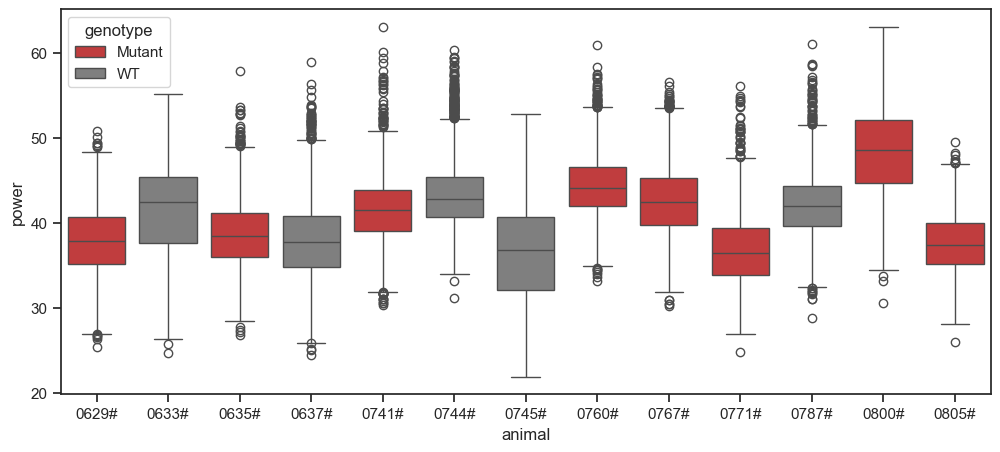

In [32]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=df_power.query('freq == 3'),
    x='animal',
    y='power',
    hue='genotype',
    palette=['tab:red', 'tab:grey'],
    hue_order=['Mutant', 'WT'],
    whis=1.5
)